In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [51]:
df = pd.read_csv('./text.csv',delimiter=',',encoding='utf-8')
print(df.head())

tags = df.Categories
texts = df.Sentences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
print('import done')

  Categories                                          Sentences
0  Airplanes  The wings of the airplane are just one compone...
1  Airplanes  The Wright brothers invented and flew the firs...
2  Airplanes  One the most deadly airplane accidents actuall...
3  Airplanes  Increases in carbon dioxide in the atmosphere ...
4  Airplanes  The oxygen in an airplane’s emergency oxygen m...
import done


In [52]:
num_max = 1000
# preprocess
le = LabelEncoder()
tags = le.fit_transform(tags)
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(texts)
mat_texts = tok.texts_to_matrix((texts),mode='count')
print(tags[:5])
print(mat_texts[:5])
print(tags.shape,mat_texts.shape)

[0 0 0 0 0]
[[0. 3. 4. ... 0. 0. 0.]
 [0. 5. 1. ... 0. 0. 0.]
 [0. 6. 2. ... 0. 0. 0.]
 [0. 2. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(3171,) (3171, 1000)


In [53]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y):
    model.fit(x,y,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

m = get_simple_model()
check_model(m,mat_texts,tags)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
compile done
Train on 2536 samples, validate on 635 samples
Epoch 1/10
2536/2536 [==============================] - 3s 1ms/step - loss: 

In [56]:
max_len = 100
cnn_texts_seq = tok.texts_to_sequences(texts)
print(cnn_texts_seq[0])
cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)
print(cnn_texts_mat[0])
print(cnn_texts_mat.shape)

[1, 992, 2, 1, 768, 8, 175, 39, 2, 359, 51, 8, 271, 196, 2, 359, 11, 1, 537, 43, 111, 504, 17, 906, 15, 111, 91, 196, 2, 359, 8, 3, 769]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   1 992   2   1 768
   8 175  39   2 359  51   8 271 196   2 359  11   1 537  43 111 504  17
 906  15 111  91 196   2 359   8   3 769]
(3171, 100)


In [57]:
def get_cnn_model_v1():   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        20,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

m = get_cnn_model_v1()
check_model(m,cnn_texts_mat,tags)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 20)           20000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 64)            3904      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
__________

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [60]:
df = pd.read_csv('./text.csv',delimiter=',',encoding='utf-8')
df.head()

,Categories,Sentences
0,Airplanes,The wings of the airplane are just one compone...
1,Airplanes,The Wright brothers invented and flew the firs...
2,Airplanes,One the most deadly airplane accidents actuall...
3,Airplanes,Increases in carbon dioxide in the atmosphere ...
4,Airplanes,The oxygen in an airplane’s emergency oxygen m...


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 2 columns):
Categories    3171 non-null object
Sentences     3171 non-null object
dtypes: object(2)
memory usage: 49.6+ KB


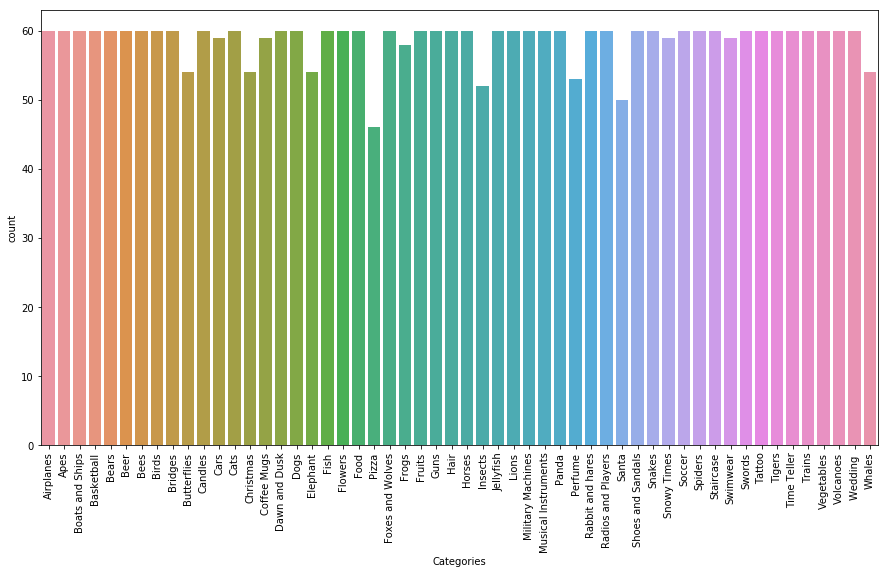

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
g = sns.countplot(df.Categories,ax=ax)
g.set_xticklabels(df.Categories.unique(),rotation=90)


In [63]:
X = df.Categories
Y = df.Sentences
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [64]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [65]:
type(Y_train)

numpy.ndarray

In [66]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [67]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [68]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [70]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 2156 samples, validate on 539 samples
Epoch 1/10
2156/2156 [==============================] - 6s 3ms/step - loss: -24677.3030 - acc: 0.0000e+00 - val_loss: -24859.5019 - val_acc: 0.0019
Epoch 2/10
2156/2156 [==============================] - 6s 3ms/step - loss: -24676.7958 - acc: 0.0000e+00 - val_loss: -24859.5019 - val_acc: 0.0019


In [ ]:
import tflearn
model = tflearn.DNN(net, tensorboard_dir='tflearn_logs')
mode.summary()